In [135]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Data Processing

Massage the data and prepare for plotting.

In [136]:

log_data  = open('review_screp.out', 'r')

    
execution = []
count = []
mem_usage = []

for line in log_data:
    elements = line.split('::')
    date_time = datetime.strptime(elements[0].strip(), '%d/%m/%Y %H:%M:%S')
    
    if 'memory used in MB' in elements[1]:
        mem_used_in_mb = float(elements[1].split(':')[1].strip().split(' ')[0])
        mem_usage.append([date_time, mem_used_in_mb])
    elif 'Reviews scanned so far' in elements[1]:
        reviews_scanned = int(elements[1].split('&&')[0].split(':')[1].strip())
        count.append([date_time, reviews_scanned])
    elif 'date in process:' in elements[1]:
        split_log = elements[1].split(',')
        extract_from = split_log[0].split(' ')
        ignored = 'is before our start date!!' in split_log[-1]
        execution.append([date_time, ignored])
        # we ignore the last few lines

                   
df_execution = pd.DataFrame(execution, columns=['date_time', 'is_ignored'])
df_count = pd.DataFrame(count, columns=['date_time', 'reviews_scanned'])
df_mem_usage = pd.DataFrame(mem_usage, columns=['date_time', 'mem_used_in_MB'])


# Find out the datetime when a review was considered for the very first time.

I know the date, thought an exact datetime object shall make for a better plot, though may be completely uncessary.

In [140]:
considered_datetime = df_execution[df_execution['is_ignored'] == False].iloc[0, 0]
considered_datetime

label_list = [(considered_datetime, 'First Review Considered', 'g')]

# Python Memory Usage

Please do note that this does not calculate the memory used by Selenium JVM.

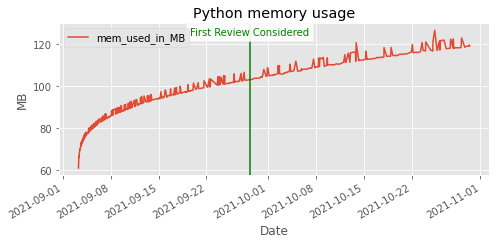

In [141]:
df_mem_usage.plot(x='date_time', y='mem_used_in_MB')
plt.title('Python memory usage')
plt.ylabel('MB')
plt.xlabel('Date')
plt.legend()

ax = plt.gca()

for date_point, label, clr in label_list:
    plt.axvline(x=date_point, color=clr)
    plt.text(date_point, ax.get_ylim()[1]-4, label,
             horizontalalignment='center',
             verticalalignment='center',
             color=clr,
             bbox=dict(facecolor='white', alpha=0.9))
plt.show()

# Reviews processed per day

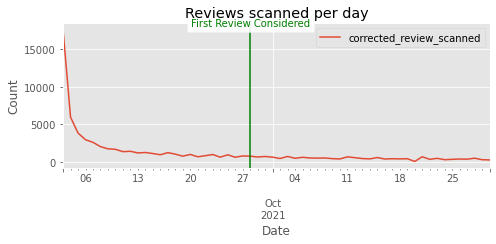

In [144]:
df_count_group_by_per_day = df_count.groupby(pd.Grouper(key='date_time',axis=0,freq='1D')).max().reset_index()
df_count_group_by_per_day['corrected_review_scanned'] = df_count_group_by_per_day['reviews_scanned'] - df_count_group_by_per_day['reviews_scanned'].shift(1)
# replace the first row NaN with value from reviews_scanned. There are better ways of doing this, but meh...
df_count_group_by_per_day.corrected_review_scanned.fillna(df_count_group_by_per_day.reviews_scanned, inplace=True)
df_count_group_by_per_day['corrected_review_scanned'] = df_count_group_by_per_day['corrected_review_scanned'].astype('int')
df_count_group_by_per_day.plot(x='date_time', y='corrected_review_scanned')
plt.title('Reviews scanned per day')
plt.ylabel('Count')
plt.xlabel('Date')

ax = plt.gca()

for date_point, label, clr in label_list:
    plt.axvline(x=date_point, color=clr)
    plt.text(date_point, ax.get_ylim()[1]-4, label,
             horizontalalignment='center',
             verticalalignment='center',
             color=',
             bbox=dict(facecolor='white', alpha=0.9))

plt.show()